In [1]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions
library(mltools)
library(data.table)
library(VIM)
library(lubridate)
library(caret)
library(CatEncoders)
library(ROSE)
library(catboost)
library(UBL)
library(DMwR)
# package for pr.curve
library(PRROC)
library(ROCR)
library(gbm)
library(xgboost)
## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

#list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions
library(jsonlite)
library(stringr)
library(feather)
#group_by
library(dplyr)
#plot, ggplot
library(ggplot2)
library(ggpubr)
## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

print("Reading in files and addressing JSON data...")
#assign correct data types and appropriate column names 
col_types <- cols(
  channelGrouping = col_character(),
  customDimensions = col_character(),
  date = col_datetime(), # Parses YYYYMMDD
  #date = col_integer(), #lets do the conversion later after ROSE
  device = col_character(),
  fullVisitorId = col_character(),
  geoNetwork = col_character(),
  hits = col_skip(), # MASSIVE amount of data!
  #sessionId = col_character(), # not present in v2 comp; not used anwyay
  socialEngagementType = col_skip(), # Skip as always "Not Socially Engaged"
  totals = col_character(),
  trafficSource = col_character(),
  visitId = col_integer(), # visitId & visitStartTime look identical in all but 5000 cases
  visitNumber = col_integer(),
  visitStartTime = col_integer() # Convert to POSIXlt later,
  #visitStartTime = col_datetime()
  )
# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

#list.files(path = "../input")
train <- read_csv("../input/ga-customer-revenue-prediction/train_v2.csv", col_types = col_types) 
test <- read_csv("../input/ga-customer-revenue-prediction/test_v2.csv",  col_types = col_types)

#which columns includes JSON, JSON-like data
#JSON columns are "device", "geoNetwork", "totals", "trafficSource", "customDimensions"
unsnake <- . %>%
  str_replace_all(c("\\[\\]" = "[{}]", # empty element must contain dictionary
                    "^\\[|\\]$" = "", # remove initial and final brackets
                    "(\\[|\\{|, |: |', )'" = "\\1\"", # open single- to double-quote (on key or value)
                    "'(\\]|\\}|: |, )" = '\"\\1')) # close quote

tr_device <- paste("[", paste(train$device, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_geoNetwork <- paste("[", paste(train$geoNetwork, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_totals <- paste("[", paste(train$totals, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_trafficSource <- paste("[", paste(train$trafficSource, collapse = ","), "]") %>% fromJSON(flatten = T)

tr_customDimensions <- paste("[", paste(unsnake(train$customDimensions), collapse = ","), "]") %>% fromJSON(flatten = T)

te_device <- paste("[", paste(test$device, collapse = ","), "]") %>% fromJSON(flatten = T)
te_geoNetwork <- paste("[", paste(test$geoNetwork, collapse = ","), "]") %>% fromJSON(flatten = T)
te_totals <- paste("[", paste(test$totals, collapse = ","), "]") %>% fromJSON(flatten = T)
te_trafficSource <- paste("[", paste(test$trafficSource, collapse = ","), "]") %>% fromJSON(flatten = T)

te_customDimensions <- paste("[", paste(unsnake(test$customDimensions), collapse = ","), "]") %>% fromJSON(flatten = T)

#Combine to make the full training and test sets. campaignCode in train is dropped.
flat.train <- train %>%
    cbind(tr_device, tr_geoNetwork, tr_totals, tr_trafficSource, tr_customDimensions) %>%
    select(-device, -geoNetwork, -totals, -trafficSource, -customDimensions, -campaignCode)
    
flat.test <- test %>%
    cbind(te_device, te_geoNetwork, te_totals, te_trafficSource, te_customDimensions) %>%
    select(-device, -geoNetwork, -totals, -trafficSource, -customDimensions)

#Remove temporary tr_ and te_ sets
rm(tr_device); rm(tr_geoNetwork); rm(tr_totals); rm(tr_trafficSource); rm(tr_customDimensions)
rm(te_device); rm(te_geoNetwork); rm(te_totals); rm(te_trafficSource); rm(te_customDimensions)

flat.train.red <- flat.train %>%
    select(-browserVersion, -browserSize, -operatingSystemVersion, -mobileDeviceInfo, -mobileDeviceBranding, -mobileDeviceModel, 
           -mobileInputSelector, -mobileDeviceMarketingName, -flashVersion, -language, -screenColors, 
           -screenResolution, -cityId,-latitude, -longitude, -networkLocation, -visits, -bounces, -newVisits, 
           -isTrueDirect, -adwordsClickInfo.criteriaParameters, -adwordsClickInfo.isVideoAd, -index)

flat.test.red <- flat.test %>%
    select(-browserVersion, -browserSize, -operatingSystemVersion, -mobileDeviceInfo, -mobileDeviceBranding, -mobileDeviceModel, 
           -mobileInputSelector, -mobileDeviceMarketingName, -flashVersion, -language, -screenColors, 
           -screenResolution, -cityId,-latitude, -longitude, -networkLocation, -visits, -bounces, -newVisits, 
           -isTrueDirect, -adwordsClickInfo.criteriaParameters, -adwordsClickInfo.isVideoAd, -index)

#setequal(names(flat.train.red), names(flat.test.red))
## Saving data
#write.csv(flat.train.red, "train_flat.csv", row.names = F)
#write.csv(flat.test.red, "test_flat.csv", row.names = F)

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.4     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: colorspace

Loading required package: grid

VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.


Suggestions and bug-reports can be submitted at: https://github.co

[1] "Reading in files and addressing JSON data..."


In [2]:
print("Data preparation...")
#----------------------------------
dup_train <- flat.train.red
dup_test <- flat.test.red
print("Combining train and test samples...")
dup_train <- rbind(dup_train, dup_test)
#attributes type conversion
dup_train$visitId <- as.character(dup_train$visitId)
# Numeric type conversion
cols.nam <- c("visitNumber", "visitStartTime", "hits","pageviews","sessionQualityDim","timeOnSite",
             "transactions","transactionRevenue","totalTransactionRevenue")
dup_train[cols.nam] <- sapply(dup_train[cols.nam],as.numeric)
#----------------------------------------
print("Removing near-zero variance attributes...")
nzv <- nearZeroVar(dup_train)
dup_train <- dup_train[, -nzv]

print("Identifying highly correlated attributes...")
train.cor <-  cor(select_if(dup_train, is.numeric), use = "complete.obs")
high.cor.att <- findCorrelation(train.cor, cutoff = .75, names=TRUE)#to drop pageviews and transactionRevenue
# pageviews and transactionRevenue highly correlated with hits and totalTransactionRevenue recpectively
# The dataset data dictionary also suggests using totalTransactionRevenue instead of transactionRevenue 
# as it is deprecated.
dup_train <- select(dup_train, -c(all_of(high.cor.att)))
#-----------------------------------------
print("Missing Values Ratio...")
#-----------------------------------------
funcMissRatio <- function(x, y){
    n <- vector()
    n <- rep(NA, length(x))
    missRatio <- cbind(x, n)

    for (i in 1:length(x)){
        y[x[i]][y[x[i]] == "(not set)"] <- NA
        y[x[i]][y[x[i]] == "not available in demo dataset"] <- NA
        y[x[i]][y[x[i]] == "unknown.unknown"] <- NA
        y[x[i]][y[x[i]] == "(none)"] <- NA
        y[x[i]][y[x[i]] == "(not provided)"] <- NA
        missRatio[i, 2] <- sum(is.na(y[x[i]]))/nrow(y)*100
    }
    print(missRatio)
    return(y)
}
# Start we geographical data as we will use it for further impute other attributes NAs, e.g., continent, subContinent
cols.nam <- c("continent", "subContinent", "country", "metro", "city", "region", "networkDomain")
dup_train <- funcMissRatio(cols.nam, dup_train)
#--------------------------------------------
print("Imputing NAs...")
#if all geo data are NA in the row
dup_train$continent[which(is.na(dup_train$networkDomain)&is.na(dup_train$city)& is.na(dup_train$metro)
    &is.na(dup_train$region)&is.na(dup_train$country) 
    &is.na(dup_train$continent)& is.na(dup_train$subContinent))] <- names(which.max(table(dup_train$continent[!is.na(dup_train$continent)])))
#sum(is.na(dup_train$continent))
#------------------------------------------
#region, city, networkDomain for some continent == NA are available
#from those we can extract continent value
temp <- dup_train %>%
    group_by(region) %>%
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$region)), dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$region)),
                                c("region")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.region.."))
nullatt <- rename(nullatt, c("region" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.region...."))

nullatt <- merge(temp, nullatt, by = c("region")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$region)), nullatt$narows)
dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#------------------------------------------
temp <- dup_train %>%
    group_by(city) %>%
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$city)), dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$city)),
                                c("city")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.city.."))
nullatt <- rename(nullatt, c("city" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.city...."))

nullatt <- merge(temp, nullatt, by = c("city")) 
nullatt <- nullatt[order(nullatt$narows),]

#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$city)), nullatt$narows)
dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#-------------------------------------------
temp <- dup_train %>%
    group_by(networkDomain) %>%
    filter(!is.null(names(which.max(table(continent[!is.na(continent)]))))&!is.na(continent)) %>% #some networkDomain groups has no corresponding 
# continent result in NULL value, we filter them out to avoid error in summarize
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), 
                      dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), c("networkDomain")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.networkDomain.."))
nullatt <- rename(nullatt, c("networkDomain" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.networkDomain...."))

nullatt <- merge(temp, nullatt, by = c("networkDomain")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#----------------------------------------------
# The corresponding networkDomain data do not provide any geo info, we may want to set them to NA
dup_train$continent[which(is.na(dup_train$continent))] <- names(which.max(table(dup_train$continent[!is.na(dup_train$continent)])))
#sum(is.na(dup_train$continent))
#-----------------------------------------------
#subContinent
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(subContinent)) %>%
    summarize(maxlevel = names(which.max(table(subContinent[!is.na(subContinent)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$subContinent)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$subContinent))))
#nullatt
nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.subContinent.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$subContinent)), nullatt$narows)

dup_train$subContinent[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$subContinent))
#--------------------------------------------
#country
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(country)) %>%
    summarize(maxlevel = names(which.max(table(country[!is.na(country)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$country)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$country))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.country.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$country)), nullatt$narows)

dup_train$country[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$country))
#---------------------------------------------
#networkDomain
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent, country) %>%
    filter(!is.na(networkDomain)) %>%
    summarize(maxlevel = names(which.max(table(networkDomain[!is.na(networkDomain)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$networkDomain)),
                                c("totalTransactionRevenue", "continent", "subContinent", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$networkDomain))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.networkDomain.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent", "country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$networkDomain[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$networkDomain))
# Second round to addess NAs based on continent
# if (setequal(which(is.na(dup_train$timeOnSite)), nullatt$narows) == FALSE)
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(networkDomain)) %>%
    summarize(maxlevel = names(which.max(table(networkDomain[!is.na(networkDomain)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$networkDomain)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$networkDomain))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.networkDomain.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$networkDomain[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$networkDomain))
#----------------------------------------
#city
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent, country) %>%
    filter(!is.na(city)) %>%
    summarize(maxlevel = names(which.max(table(city[!is.na(city)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$city)),
                                c("totalTransactionRevenue", "continent", "subContinent", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$city))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.city.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent", "country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$country)), nullatt$narows)

dup_train$city[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$city))
# second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(city)) %>%
    summarize(maxlevel = names(which.max(table(city[!is.na(city)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$city)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$city))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.city.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$city[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$city))
# third round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(city)) %>%
    summarize(maxlevel = names(which.max(table(city[!is.na(city)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$city)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$city))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.city.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$city[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$city))
#---------------------------------------------
print("Missing Values Ratio...")
# Computing NA ratio
cols.nam <- c("visitNumber", "hits", "sessionQualityDim", "timeOnSite")
dup_train <- funcMissRatio(cols.nam, dup_train)
# sessionQualityDim
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(sessionQualityDim)) %>%
    summarize(meanatt = mean(sessionQualityDim))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$sessionQualityDim)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$sessionQualityDim))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.sessionQualityDim.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$sessionQualityDim[nullatt$narows] <- nullatt$meanatt
# The second round to addess NAs based on continent
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(sessionQualityDim)) %>%
    summarize(meanatt = mean(sessionQualityDim))
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

#sum(is.na(dup_train$sessionQualityTime))
which(is.na(dup_train$sessionQualityTime))
nullatt <- data.frame(dup_train[which(is.na(dup_train$sessionQualityDim)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$sessionQualityDim))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.sessionQualityDim.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$sessionQualityDim[nullatt$narows] <- nullatt$meanatt
#----------------------------------------
#timeOnSite
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(timeOnSite)) %>%
    summarize(meanatt = mean(timeOnSite))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$timeOnSite)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$timeOnSite))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.timeOnSite.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$timeOnSite[nullatt$narows] <- nullatt$meanatt
#sum(is.na(dup_train$timeOnSite))
#if (setequal(which(is.na(dup_train$timeOnSite)), nullatt$narows) == FALSE)
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(timeOnSite)) %>%
    summarize(meanatt = mean(timeOnSite))
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$timeOnSite)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$timeOnSite))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.timeOnSite.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$timeOnSite[nullatt$narows] <- nullatt$meanatt
#---------------------------------------
# channelGrouping NAs: no NA but has (Other) level
dup_train %>% 
  filter(!is.na(channelGrouping)) %>%
  count(channelGrouping, sort = TRUE)
#----------------------------------------
print("Missing Values Ratio...")
cols.nam <- c("operatingSystem","browser","isMobile","deviceCategory")
dup_train <- funcMissRatio(cols.nam, dup_train)
#-----------------------------------------------
# operatingSystem
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), deviceCategory) %>%
    filter(!is.na(operatingSystem)) %>%
    summarize(maxlevel = names(which.max(table(operatingSystem[!is.na(operatingSystem)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$operatingSystem)),
                                c("totalTransactionRevenue", "deviceCategory")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$operatingSystem))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.operatingSystem.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","deviceCategory")) 
nullatt <- nullatt[order(nullatt$narows),]

#setequal(which(is.na(dup_train$operatingSystem)), nullatt$narows)

dup_train$operatingSystem[nullatt$narows] <- nullatt$maxlevel
#----------------------------------------
# browser
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), deviceCategory, operatingSystem) %>%
    filter(!is.na(browser)) %>%
    summarize(maxlevel = names(which.max(table(browser[!is.na(browser)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$browser)),
                                c("totalTransactionRevenue", "deviceCategory", "operatingSystem")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$browser))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.browser.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","deviceCategory", "operatingSystem")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$browser[nullatt$narows] <- nullatt$maxlevel
#--------------------------------------
#str(dup_train)
print("Missing Values Ratio...")
cols.nam <- c("source", "medium", "keyword", "referralPath", "adContent",
               "adwordsClickInfo.slot", "adwordsClickInfo.gclId", 
              "adwordsClickInfo.adNetworkType", "value")
dup_train <- funcMissRatio(cols.nam, dup_train)
#------------------------------------------------
# source
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), country) %>%
    filter(!is.na(source)) %>%
    summarize(maxlevel = names(which.max(table(source[!is.na(source)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$source)),
                                c("totalTransactionRevenue", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$source))))
#nullatt
nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.source.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","country")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$source[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$source))
#----------------------------------------------------
#medium
# We can address NAs at country then subContinent and finally continent level
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), country) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$medium)), nullatt$narows)

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
# Second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), subContinent) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
# Third round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$medium)), nullatt$narows)

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$medium))
#-----------------------------------------------------
# value
#dup_train$value[dup_train$value == "(not set)"] <- NA
#missRatio <- sum(is.na(dup_train$value))/nrow(dup_train)*100
#missRatio

temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), subContinent) %>%
    filter(!is.na(value)) %>%
    summarize(maxlevel = names(which.max(table(value[!is.na(value)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$value)),
                                c("totalTransactionRevenue", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$value))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.value.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$value)), nullatt$narows)

dup_train$value[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$value))
# Second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(value)) %>%
    summarize(maxlevel = names(which.max(table(value[!is.na(value)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$value)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$value))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.value.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$value)), nullatt$narows)

dup_train$value[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$value))
# Addressing a few remaining NAs in value
dup_train$value[which(is.na(dup_train$value))] <- names(which.max(table(dup_train$value[!is.na(dup_train$value)])))
#sum(is.na(dup_train$value))
print("Checking if all interesting attributes NAs have been addressed...")
cols.nam <- c("visitNumber","hits","sessionQualityDim","timeOnSite","totalTransactionRevenue",
              "operatingSystem","browser","isMobile","deviceCategory", 
              "continent", "subContinent", "country", "region", "metro", "city", "networkDomain", 
            "source", "medium", "keyword", "referralPath", "adContent",
              "adwordsClickInfo.slot", "adwordsClickInfo.adNetworkType", "value")

dup_train <- funcMissRatio(cols.nam, dup_train)

[1] "Data preparation..."
[1] "Combining train and test samples..."
[1] "Removing near-zero variance attributes..."
[1] "Identifying highly correlated attributes..."
[1] "Missing Values Ratio..."
     x               n                 
[1,] "continent"     "0.13739818363298"
[2,] "subContinent"  "0.13739818363298"
[3,] "country"       "0.13739818363298"
[4,] "metro"         "76.5958142607845"
[5,] "city"          "58.0076742027919"
[6,] "region"        "56.9243186727876"
[7,] "networkDomain" "45.6780000815194"
[1] "Imputing NAs..."
[1] "Missing Values Ratio..."
     x                   n                 
[1,] "visitNumber"       "0"               
[2,] "hits"              "0"               
[3,] "sessionQualityDim" "39.5878338861173"
[4,] "timeOnSite"        "50.1429907968336"


integer(0)

channelGrouping,n
<chr>,<int>
Organic Search,937341
Social,391852
Direct,349210
Referral,270812
Paid Search,58461
Display,58359
Affiliates,43748
(Other),143


[1] "Missing Values Ratio..."
     x                 n                     
[1,] "operatingSystem" "0.767657254330247"   
[2,] "browser"         "0.000568740325490088"
[3,] "isMobile"        "0"                   
[4,] "deviceCategory"  "0"                   
[1] "Missing Values Ratio..."
      x                                n                    
 [1,] "source"                         "0.00331765189869218"
 [2,] "medium"                         "32.105580954024"    
 [3,] "keyword"                        "95.3229165383051"   
 [4,] "referralPath"                   "68.5936852761661"   
 [5,] "adContent"                      "96.4223863775317"   
 [6,] "adwordsClickInfo.slot"          "95.9297624656031"   
 [7,] "adwordsClickInfo.gclId"         "95.9223688413717"   
 [8,] "adwordsClickInfo.adNetworkType" "95.9297624656031"   
 [9,] "value"                          "18.6649200019337"   
[1] "Checking if all interesting attributes NAs have been addressed..."
      x                     

In [35]:
print("Aggregating visitor level data...")
# Function to calculate each categorical attribute mode
catMode = function(x){
    y = names(which.max(table(x)))
    return(y)
} 
#-----------------------------------------
# Generating more attributes extracted from date e.g., day of the week, day of the month, month
imbal.data <- dup_train
imbal.data$month <- as.character(month(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data$mday <- as.character(mday(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data$wday <- as.character(wday(lubridate::as_datetime(imbal.data$visitStartTime)))
imbal.data$hour <- as.character(hour(lubridate::as_datetime(imbal.data$visitStartTime)))

imbal.data <- select(imbal.data, -c("visitId", "adwordsClickInfo.gclId", "region", "metro", 
                                 "keyword", "referralPath", "adContent",
              "adwordsClickInfo.slot", "adwordsClickInfo.adNetworkType", "visitStartTime"))

imbal.data$totalTransactionRevenue[which(is.na(imbal.data$totalTransactionRevenue))] <- 0
str(imbal.data)
#--------------------------------------------------
# transforming to visitor level data
temp1.imbal.data <- imbal.data %>%
filter(visitNumber == 1) 
temp1.imbal.data$freqVisit <- (rep(0, nrow(temp1.imbal.data)))
temp1.imbal.data$totalTransactionRevenue <- log1p(temp1.imbal.data$totalTransactionRevenue)
names(temp1.imbal.data)[names(temp1.imbal.data) == "date"] <- "ldate"

temp2.imbal.data <- imbal.data %>% 
group_by(fullVisitorId) %>%
filter(visitNumber != 1) %>%
summarize(channelGrouping = catMode(channelGrouping), visitNumber = max(visitNumber),
         ldate = max(date), browser = catMode(browser), operatingSystem = catMode(operatingSystem), 
         isMobile = catMode(isMobile), deviceCategory = catMode(deviceCategory), continent = catMode(continent), 
         subContinent = catMode(subContinent), country = catMode(country), city = catMode(city),
          networkDomain = catMode(networkDomain),
         hits = mean(hits), sessionQualityDim = mean(sessionQualityDim), timeOnSite = mean(timeOnSite),
         totalTransactionRevenue = log1p(sum(totalTransactionRevenue)), source = catMode(source),
         medium = catMode(medium), value = catMode(value), month = catMode(month), mday = catMode(mday),
         wday = catMode(wday), hour = catMode(hour), 
         freqVisit = as.numeric(max(date) - min(date))/max(visitNumber))
temp2.imbal.data <- as.data.frame(temp2.imbal.data)

imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)

'data.frame':	2109926 obs. of  30 variables:
 $ channelGrouping               : chr  "Organic Search" "Referral" "Direct" "Organic Search" ...
 $ date                          : POSIXct, format: "2017-10-16" "2017-10-16" ...
 $ fullVisitorId                 : chr  "3162355547410993243" "8934116514970143966" "7992466427990357681" "9075655783635761930" ...
 $ visitId                       : chr  "1508198450" "1508176307" "1508201613" "1508169851" ...
 $ visitNumber                   : num  1 6 1 1 1 1 1 1 1 2 ...
 $ visitStartTime                : num  1.51e+09 1.51e+09 1.51e+09 1.51e+09 1.51e+09 ...
 $ browser                       : chr  "Firefox" "Chrome" "Chrome" "Chrome" ...
 $ operatingSystem               : chr  "Windows" "Chrome OS" "Android" "Windows" ...
 $ isMobile                      : logi  FALSE FALSE TRUE FALSE FALSE FALSE ...
 $ deviceCategory                : chr  "desktop" "desktop" "mobile" "desktop" ...
 $ continent                     : chr  "Europe" "Americas" "Ame

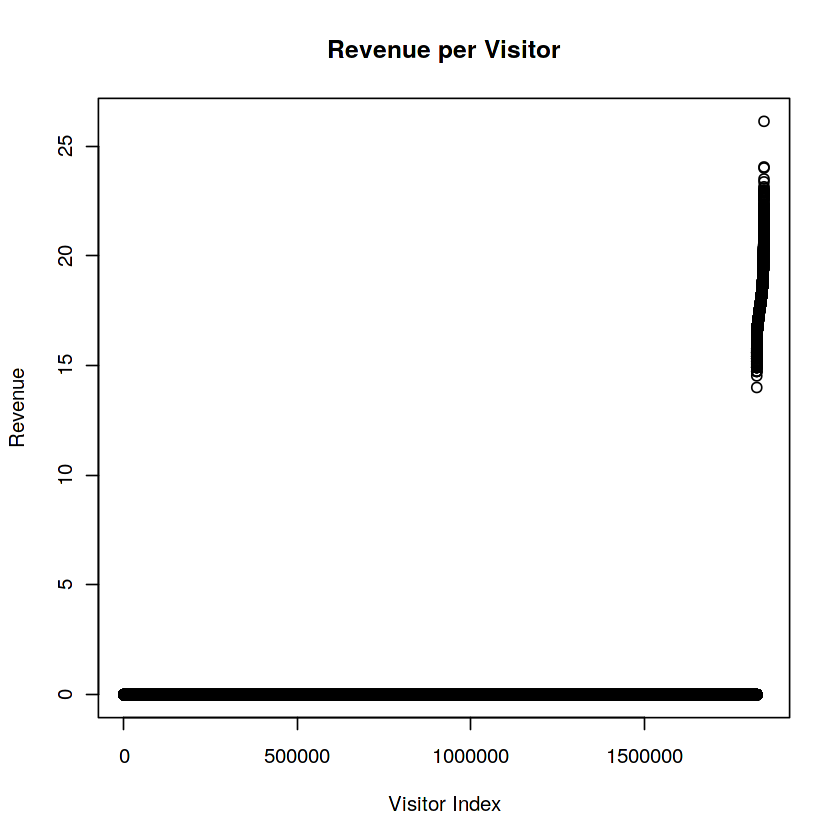

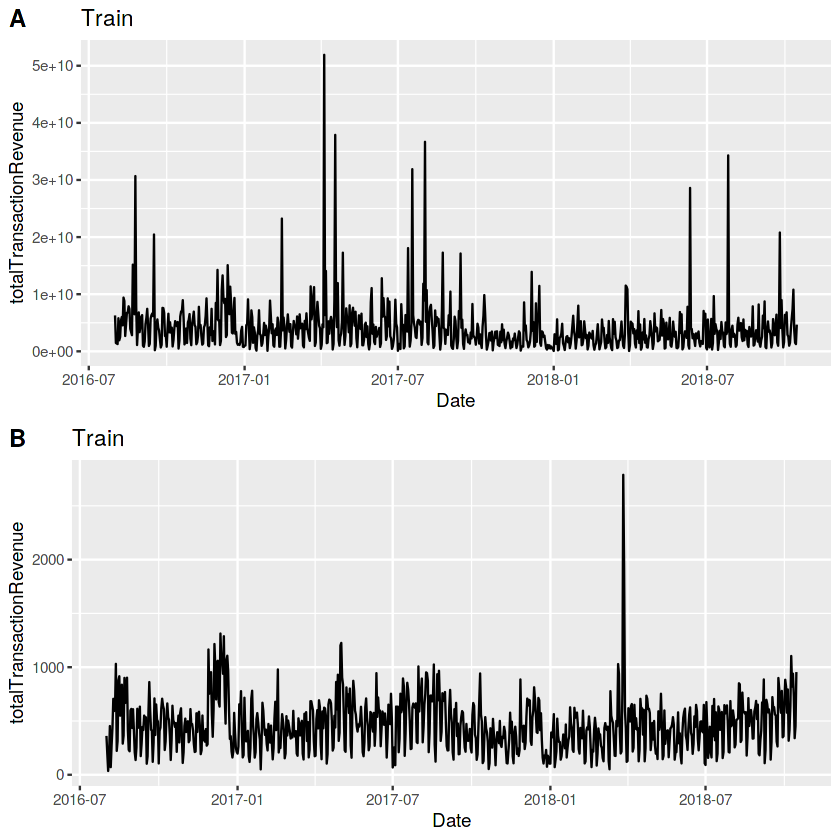

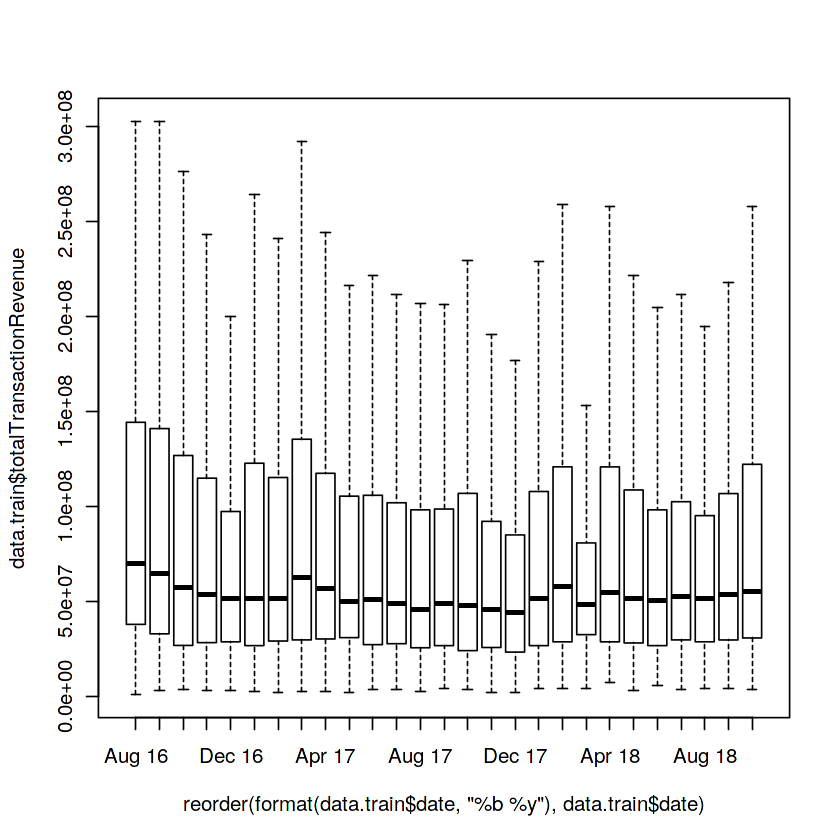

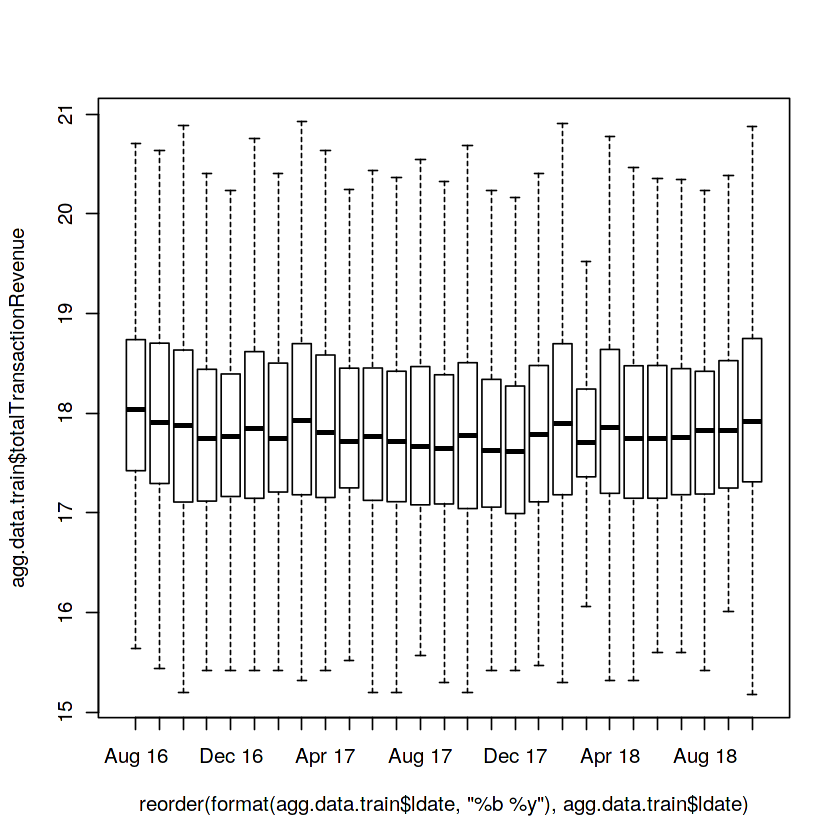

In [4]:
# session level data
str(dup_train)
# visitor level data replacing totalTransactionRevenue with log1p(sum(totalTransactionRevenue))
str(imbal.data)
# This plot shows a highly imbalanced and skewed dataset
plot(sort(imbal.data$totalTransactionRevenue), main = "Revenue per Visitor", xlab = "Visitor Index", ylab = "Revenue")
#------------------------------------------------
# Now, let's see how the revenue changes over time and how aggregating data at visitor level changes the revenue trend
print("Plotting totalTransactionRevenue vs. date...")
# how log1p or visitor level data transform the dataset e.g., remove random errors, a ibt of seasonality
data.train <- dup_train %>%
  select(date, totalTransactionRevenue) %>%
  filter(!is.na(totalTransactionRevenue))

temp1 <- data.train %>%
  group_by(date) %>%
  #summarize(bCount = n(), sttr = sum(log1p(totalTransactionRevenue))) 
  summarize(bCount = n(), sttr = sum(totalTransactionRevenue)) 

agg.data.train <- imbal.data %>%
  select(ldate, totalTransactionRevenue) %>%
  filter(totalTransactionRevenue != 0)

temp2 <- agg.data.train %>%
  group_by(ldate) %>%
  summarize(bCount = n(), sttr = sum(totalTransactionRevenue)) 
  

g1 <- ggplot(temp1, aes(date, sttr))
r1 <- g1 + geom_line() 
s1 <- r1 + labs(title = "Train", x = "Date", y = "totalTransactionRevenue")

g2 <- ggplot(temp2, aes(ldate, sttr))
r2 <- g2 + geom_line() 
s2 <- r2 + labs(title = "Train", x = "Date", y = "totalTransactionRevenue")

ggarrange(s1, s2,
          labels = c("A", "B"),
          ncol = 1, nrow = 2)
# data is changing in unforween patterns over time, not a trend or repetative pattern that occurs every year
# concept drift? update the model with the most recent data
#----------------------------------------
boxplot(data.train$totalTransactionRevenue ~ reorder(format(data.train$date,'%b %y'),data.train$date), outline = FALSE) 
#----------------------------------------
boxplot(agg.data.train$totalTransactionRevenue ~ reorder(format(agg.data.train$ldate,'%b %y'),agg.data.train$ldate), outline = FALSE) 
#----------------------------------------
if(FALSE){
ggplot(data.train) +
  geom_boxplot(aes(y=log1p(totalTransactionRevenue),
                   x=reorder(format(date,'%B'),date),
                   fill=format(date,'%Y'))) +
  ylab("Revenue") + xlab('Month') + guides(fill=guide_legend(title="Year")) +
  theme_bw()
#----------------------------------------
ggplot(agg.data.train) +
  geom_boxplot(aes(y=totalTransactionRevenue,
                   x=reorder(format(ldate,'%B'),ldate),
                   fill=format(ldate,'%Y'))) +
  ylab("Revenue") + xlab('Month') + guides(fill=guide_legend(title="Year")) +
  theme_bw()
#----------------------------------------
data.train <- dup_train %>%
  select(visitStartTime, totalTransactionRevenue) %>%
  filter(!is.na(totalTransactionRevenue))#, date >= as.Date("2017-01-01") & date <= as.Date("2017-12-30"))

boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(month(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE) 
boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(wday(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE)
boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(mday(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE)
boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(hour(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE) 
}

In [41]:
# Preparing data for claccification
imbal.data$totalTransactionRevenue[which(imbal.data$totalTransactionRevenue != 0)] <- 1

cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value", "month",
             "mday", "wday", "hour", "totalTransactionRevenue")

imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
#----------------------------------------------------
# Only NetworkDoamin as it contains lots of very low frequnecy data results in many levels
print("Reducing categorical attributes' levels...")
#cols.nam <- c("browser", "networkDomain", "country", "source")
cols.nam <- c("networkDomain")
catTofac <- function(x, df){
    for (i in 1:length(x)){
        #df[,x[i]] <- fct_lump(df[,x[i]], p = 0.01, w = NULL, other_level = "(Other)")
        # We can go with n = ... to keepp more levels in the analysis
        df[,x[i]] <- fct_lump(df[,x[i]], n = 20, w = NULL, other_level = "(Other)")
    }
    return(df)
}
#dataset <- catTofac(cols.nam, dataset)
imbal.data <- catTofac(cols.nam, imbal.data)
# Not including features extracted from date for now
imbal.data <- select(imbal.data, -c(hour, mday, wday, month))
str(imbal.data)
#-----------------------------------------
print("Normalizing the dataset...")
cols.nam <- c("visitNumber", "hits", "timeOnSite", "sessionQualityDim", "freqVisit")

pp_norm <- preProcess(imbal.data[cols.nam], 
                      method = c("scale", "center"))
                      #method = c("range"))
imbal.data[cols.nam] <- predict(pp_norm, newdata = imbal.data[cols.nam])
#training <- dataset
#-----------------------------------------
print("Splitting dataset into training and test...")
test.data <- imbal.data %>%
    filter(ldate >= as.Date("2018-05-01"))
training <- imbal.data %>%
    filter(ldate < as.Date("2018-05-01"))
#str(dataset)
#str(test.data)

In [ ]:
#-------------------------------------
# Data split for training
if(FALSE){
training <- dataset %>%
    filter(ldate < as.Date("2018-01-01"))
validation <- dataset %>%
    filter(ldate >= as.Date("2018-01-01"))
}
#------------------------------------
# Addressing imbalanced class
# Including sampling in trainControl...
print(prop.table(table(training$totalTransactionRevenue)))
set.seed(1)
training$ldate <- as.numeric(training$ldate)
#smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 4500, perc.under=200)
#smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 6500, perc.under=136)
smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 6000, perc.under=150)
smote.train$ldate <- lubridate::as_datetime(smote.train$ldate)
#str(smote.train)
table(training$totalTransactionRevenue)
table(smote.train$totalTransactionRevenue)
print(prop.table(table(smote.train$totalTransactionRevenue)))
#rose.train <- ROSE(totalTransactionRevenue ~ ., data  = training)$data                         
#range(smote.train$ldate)
#table(rose.train$totalTransactionRevenue) 
#ovun.train <- ovun.sample(totalTransactionRevenue ~ ., data = training, p = 0.5, method="both")$data
#ovun.train$ldate <- lubridate::as_datetime(ovun.train$ldate)
#table(training$totalTransactionRevenue)
#table(ovun.train$totalTransactionRevenue) 
# ROSE generates samples out of feature space like date, I'd rather date within training period
#-----------------------------------
# Dealing with categorical features
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("fullVisitorId", "visitNumber", "hits", "sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate", "freqVisit")])
    return(df)
}
training <- cat.encode.func(smote.train)
#training <- cat.encode.func(training)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
#-------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
# Renaming levels for classProbs = TRUE in TrainControl                  
levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
y_train <- unlist(training[c('totalTransactionRevenue')])
x_train <- select(training, -c("totalTransactionRevenue"))
#levels(validation$totalTransactionRevenue) <- c("noRev", "Rev")
#y_valid <- unlist(validation[c('totalTransactionRevenue')])
#x_valid <- select(validation, -c("totalTransactionRevenue"))

levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
str(x_train)
#str(x_valid)
str(x_test)
#-------------------------------------
# Preparing dataset for timeSlices
temp <- x_train %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 2, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}                   
#-------------------------------------------
# Create model weights (they sum to one) for weights
#str(x_train)
#cat_att <- unlist(lapply(x_train, class))
#as.data.frame(which(cat_att == "factor"))
#cat_features = c(1, 3:11, 15:17)
#cat_features
if(FALSE){
model_weights <- ifelse(training$totalTransactionRevenue == "noRev",
                        (1/table(training$totalTransactionRevenue)[1]) * 0.5,
                        (1/table(training$totalTransactionRevenue)[2]) * 0.5)
print("Model fitting...")

set.seed(123)                   
fitControl <- trainControl(method = "timeslice",
                           classProbs = TRUE,
                           #sampling = "smote",
                           #summaryFunction = twoClassSummary,
                           summaryFunction = prSummary,
                           savePredictions = TRUE,
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)
                           #indexFinal = unlist(indexFinal)
)
                   
# Grid Search for tuning the parameters
catboost.grid <- expand.grid(depth = c(5, 6, 7),#unbal:5, c(5, 7), #c(5,6,7),7
                    learning_rate = c(0.05, 0.1, 0.5), #c(0.5,0.1,0.05),0.5
                    iterations = 200,#200, c(100,200), #c(50,100,200),200
                    l2_leaf_reg = 3,#1e-06
                    rsm = 0.8, #c(0.8,1.0),0.8
                    #class_weights <- c(0.1, 4) # when feeding imbalanced class?
                    border_count = 255)#255, c(64,128,255)) 255

model <- train(x = x_train[, !(colnames(x_train) %in% c("ldate", "fullVisitorId"))], 
               y = y_train,
               method = catboost.caret,
               #method = "gbm",
               #weights = model_weights,
               trControl = fitControl,
               tuneGrid = catboost.grid,
               #tuneLength = 3,
               metric = "AUC",
               #metric = "F", 
               task_type = "CPU",# performance settings
               thread_count = 4 # thread_count equal to the number of cpu cores which is 4  
              )

saveRDS(model, "smote.catboost.rds")
}

Catboost 

1500131 samples
     18 predictor
      2 classes: 'noRev', 'Rev' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 65521, 128049, 217175, 321276, 389018, 445475, ... 
Resampling results across tuning parameters:

  depth  learning_rate  AUC        Precision  Recall     F        
  5      0.05           0.9999309  0.9981642  0.9939164  0.9959952
  5      0.10           0.9998920  0.9982038  0.9941040  0.9961107
  5      0.50           0.9999284  0.9981302  0.9942723  0.9961594
  6      0.05           0.9999311  0.9982311  0.9939396  0.9960399
  6      0.10           0.9999095  0.9982228  0.9941380  0.9961382
  6      0.50           0.9998857  0.9981440  0.9941975  0.9961297
  7      0.05           0.9999334  0.9982610  0.9940465  0.9961112
  7      0.10           0.9998522  0.9982408  0.9940093  0.9960801
  7      0.50           0.9999246  0.9981619  0.9940011  0.9960374

Tuning parameter 'iterati

Catboost 

1500131 samples
     19 predictor
      2 classes: 'noRev', 'Rev' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 65521, 128049, 217175, 321276, 389018, 445475, ... 
Resampling results across tuning parameters:

  depth  learning_rate  AUC        Precision  Recall     F        
  5      0.05           0.9999265  0.9998890  0.9772673  0.9883229
  5      0.10           0.9999176  0.9998793  0.9791927  0.9893223
  5      0.50           0.9187680  0.9997110  0.9840866  0.9917701
  6      0.05           0.9999293  0.9998818  0.9783451  0.9888821
  6      0.10           0.9999175  0.9998500  0.9806605  0.9900700
  6      0.50           0.9918270  0.9996262  0.9862245  0.9928253
  7      0.05           0.9999271  0.9998693  0.9796647  0.9895628
  7      0.10           0.9998946  0.9998276  0.9822815  0.9908977
  7      0.50           0.9913638  0.9995183  0.9875026  0.9934248

Tuning parameter 'iterati

Catboost 

2490594 samples
     18 predictor
      2 classes: 'noRev', 'Rev' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 82180, 180458, 326306, 487108, 610425, 726117, ... 
Resampling results:

  AUC       Precision  Recall     F        
  0.999378  0.9980006  0.9895844  0.9936659

Tuning parameter 'depth' was held constant at a value of 7
Tuning
 parameter 'rsm' was held constant at a value of 0.8
Tuning
 parameter 'border_count' was held constant at a value of 255

[1] "Visualizing feature importance..."


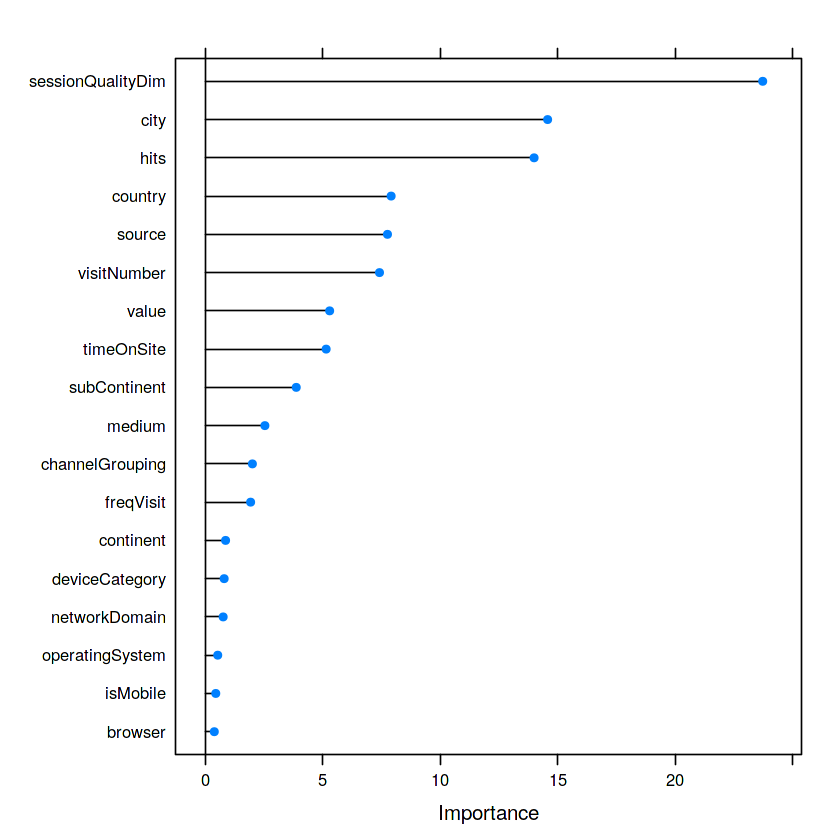

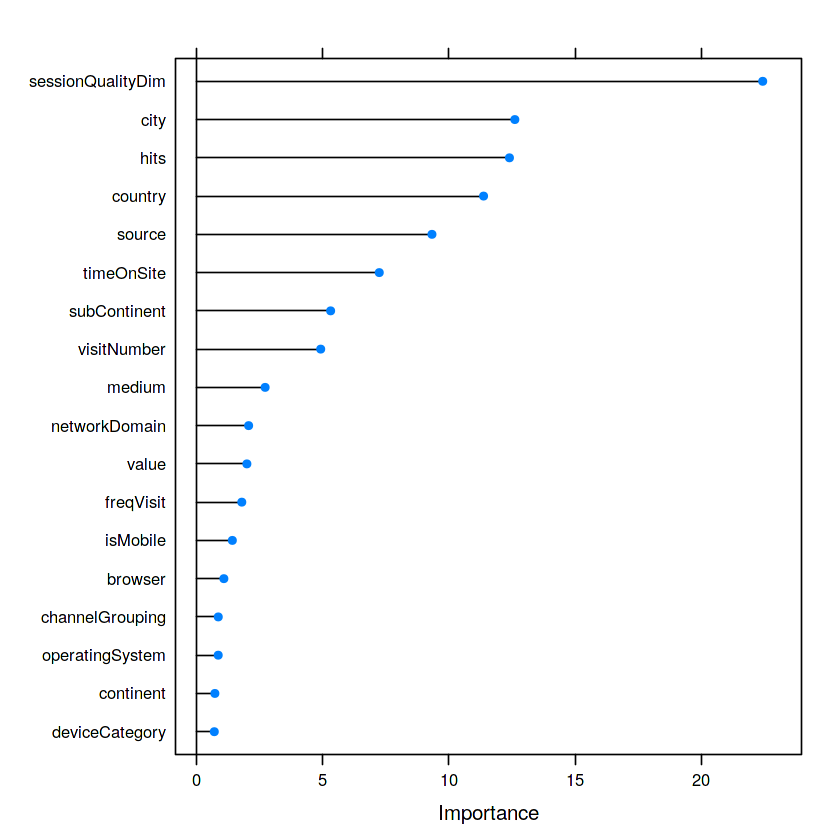

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 340101   3627
     Rev      517    742
                                          
               Accuracy : 0.988           
                 95% CI : (0.9876, 0.9883)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 0.0002853       
                                          
                  Kappa : 0.2595          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.169833        
            Specificity : 0.998482        
         Pos Pred Value : 0.589357        
         Neg Pred Value : 0.989448        
             Prevalence : 0.012664        
         Detection Rate : 0.002151        
   Detection Prevalence : 0.003649        
      Balanced Accuracy : 0.584158        
                                          
       'Positive' Class : Rev             
            

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 316638    155
     Rev    23980   4214
                                          
               Accuracy : 0.93            
                 95% CI : (0.9292, 0.9309)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2422          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.96452         
            Specificity : 0.92960         
         Pos Pred Value : 0.14946         
         Neg Pred Value : 0.99951         
             Prevalence : 0.01266         
         Detection Rate : 0.01221         
   Detection Prevalence : 0.08172         
      Balanced Accuracy : 0.94706         
                                          
       'Positive' Class : Rev             
            

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 322449    274
     Rev    18169   4095
                                          
               Accuracy : 0.9465          
                 95% CI : (0.9458, 0.9473)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2925          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.93729         
            Specificity : 0.94666         
         Pos Pred Value : 0.18393         
         Neg Pred Value : 0.99915         
             Prevalence : 0.01266         
         Detection Rate : 0.01187         
   Detection Prevalence : 0.06454         
      Balanced Accuracy : 0.94197         
                                          
       'Positive' Class : Rev             
            

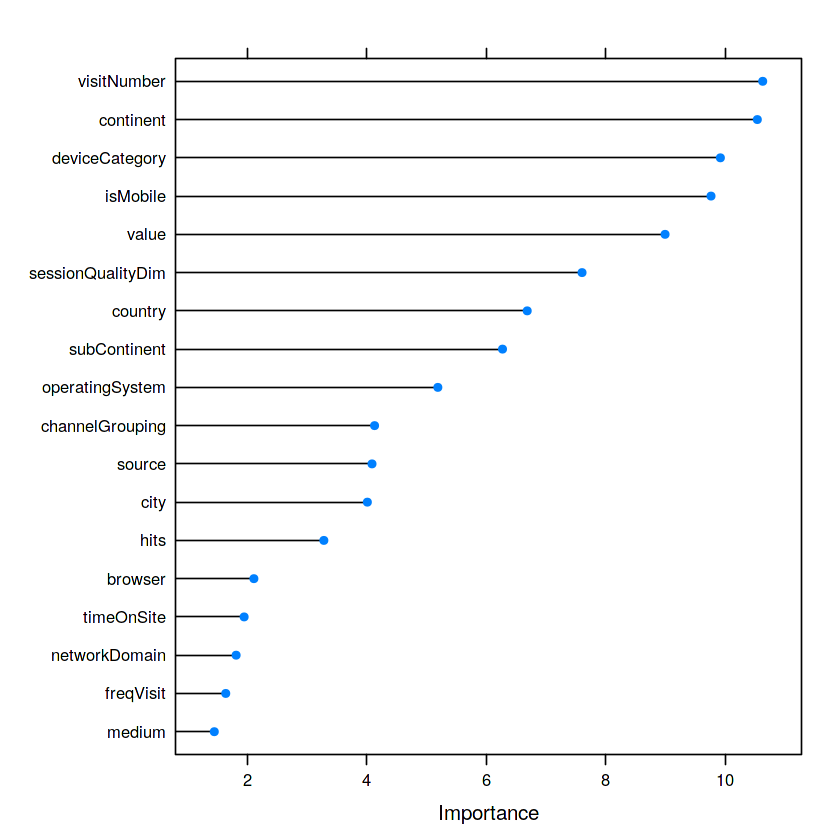

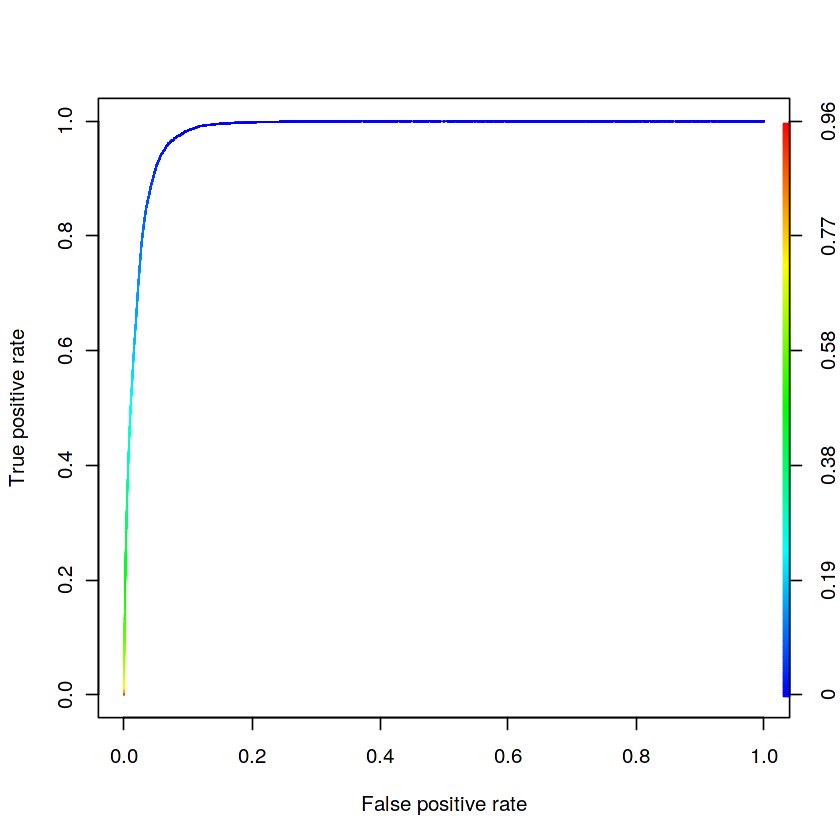

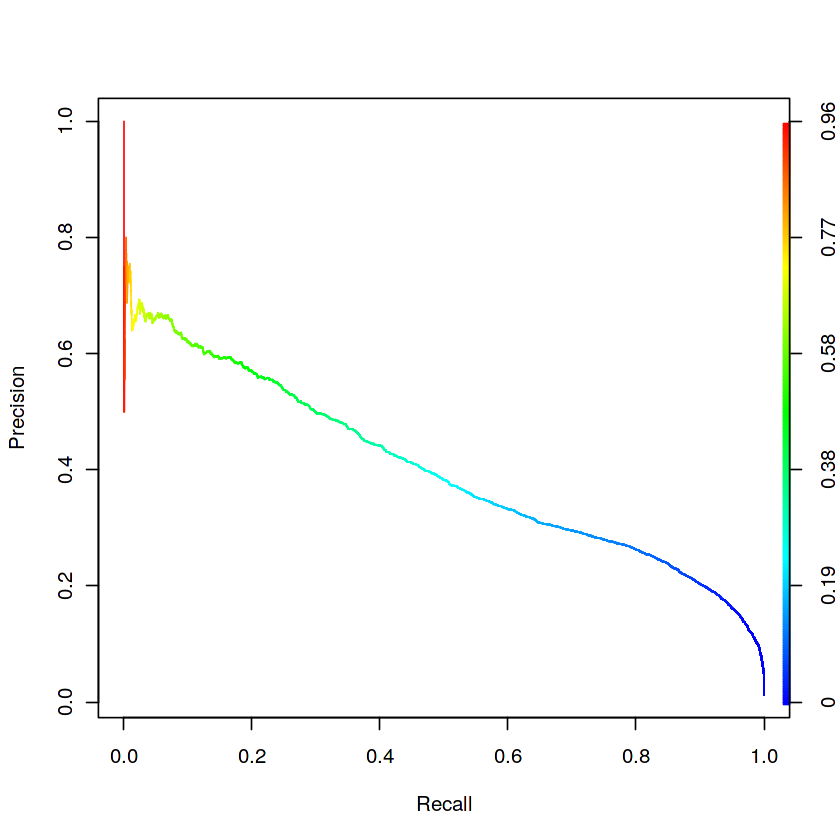

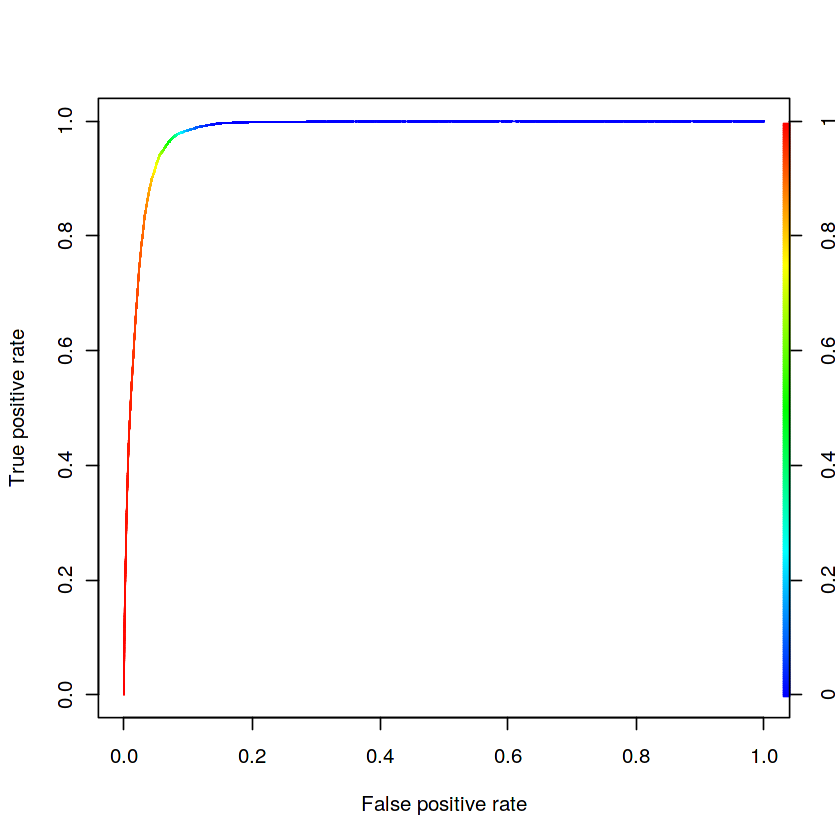

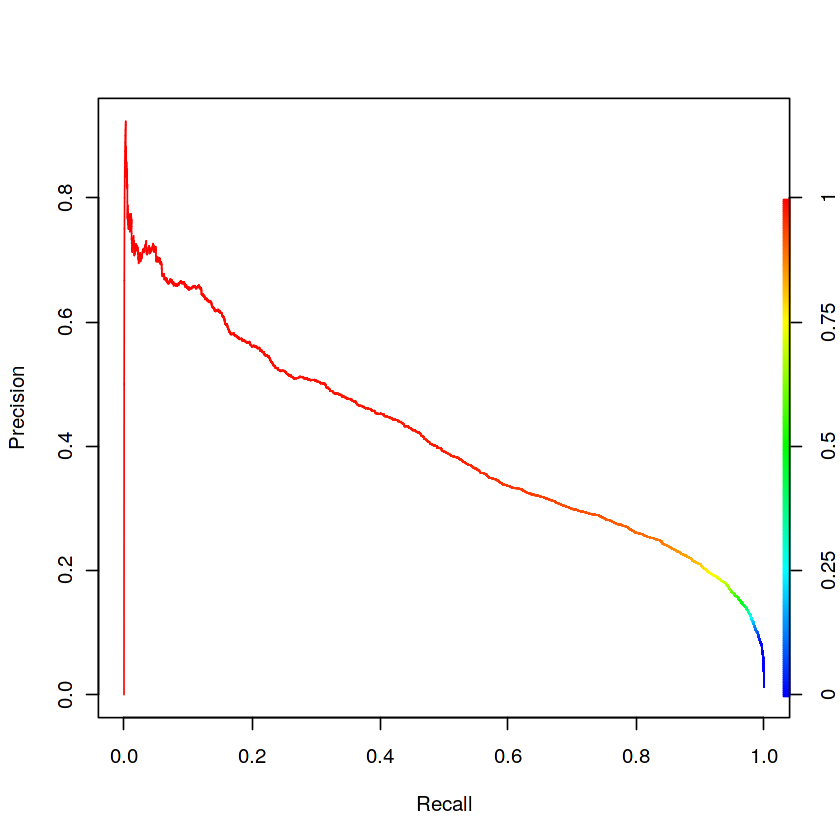

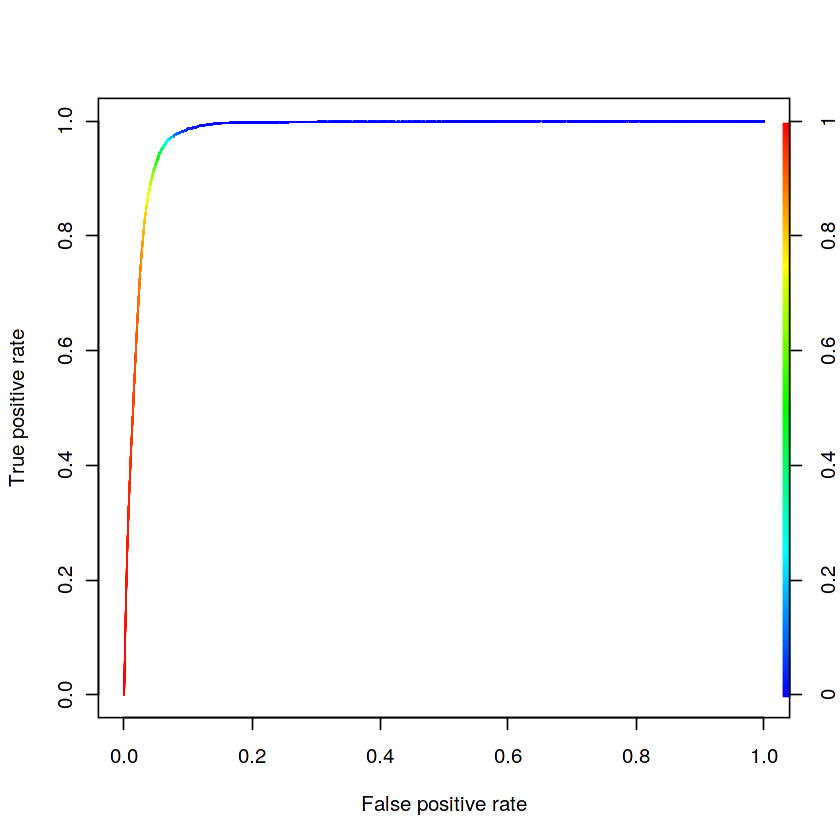

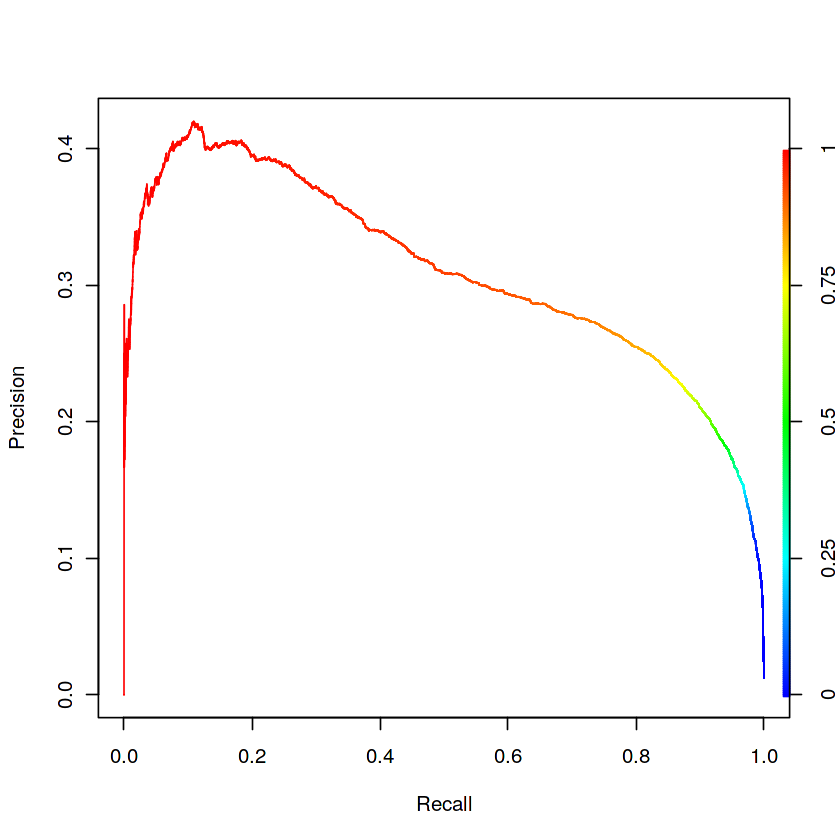

In [40]:
# three models are visualized and compared here: 
# original, weighted smote-sampled datasets using rolling window for time series cross validation
o.model <- readRDS("../input/mylatestmodels/original.rollingwin.AUC.rds")
w.model <- readRDS("../input/mylatestmodels/weights.rollingwin.AUC.rds")
s.model <- readRDS("../input/tsmodelsv2/smotesampling.rollingwin.AUC.v2.rds")
o.model
w.model
s.model
print("Visualizing feature importance...")
catImp <- varImp(o.model, scale = FALSE)
plot(catImp, top = 18)
catImp <- varImp(w.model, scale = FALSE)
plot(catImp, top = 18)
#s.model
catImp <- varImp(s.model, scale = FALSE)
plot(catImp, top = 18)
# Comparison, prediction, evaluation
# original model using based dataset
#o.model
o.pred <- predict(o.model, x_test)
#table(o.pred)
confusionMatrix(o.pred, y_test, positive = "Rev")
o.pred <- predict(o.model, x_test, type="prob")
#sum((o.pred$Rev > 0.8) == TRUE)
# visualizing original model   
#o.pr<-pr.curve(scores.class0 = o.pred$noRev, scores.class1 = o.pred$Rev, curve=TRUE)
#o.pr
#plot(o.pr)


# weighted model    
#w.model
w.pred <- predict(w.model, x_test)
#table(w.pred)
confusionMatrix(w.pred, y_test, positive = "Rev")
w.pred <- predict(w.model, x_test, type="prob")
#sum((w.pred$Rev > 0.9) == TRUE)

#w.pr<-pr.curve(scores.class0 = w.pred$noRev, scores.class1 = w.pred$Rev, curve=TRUE)
#w.pr
#plot(w.pr)

# smote sampling model
s.pred <- predict(s.model, x_test)
#table(s.pred)
confusionMatrix(s.pred, y_test, positive = "Rev")
s.pred <- predict(s.model, x_test, type="prob")
#sum((s.pred$Rev > 0.9) == TRUE)

#s.pr<-pr.curve(scores.class0 = s.pred$noRev, scores.class1 = s.pred$Rev, curve=TRUE)
#s.pr
#plot(s.pr)
pred <- prediction(o.pred$Rev, test.data$totalTransactionRevenue)
perf <- performance(pred,"tpr","fpr")
plot(perf,colorize=TRUE)
perf <- performance(pred,"prec","rec")
plot(perf,colorize=TRUE)

#library(ROCR)
pred <- prediction(w.pred$Rev, test.data$totalTransactionRevenue)
perf <- performance(pred,"tpr","fpr")
plot(perf,colorize=TRUE)
perf <- performance(pred,"prec","rec")
plot(perf,colorize=TRUE)

pred <- prediction(s.pred$Rev, test.data$totalTransactionRevenue)
perf <- performance(pred,"tpr","fpr")
plot(perf,colorize=TRUE)
perf <- performance(pred,"prec","rec")
plot(perf,colorize=TRUE)
if(FALSE){
# loading package
library(precrec)
precrec_obj <- evalmod(scores = o.pred$noRev, labels = test.data$totalTransactionRevenue)
autoplot(precrec_obj)
}

In [14]:
# Classification using xgboost
#str(training)
#levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
x_train = xgb.DMatrix(as.matrix(training %>% select(-c(totalTransactionRevenue, ldate, fullVisitorId))))
y_train = training$totalTransactionRevenue
#levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
x_test = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate, fullVisitorId))))
y_test = test.data$totalTransactionRevenue
#str(x_train)
xgb_trcontrol = trainControl(
  method = "timeslice",
  classProbs = TRUE,
  summaryFunction = prSummary,
  #savePredictions = TRUE,
  index = function_ts(time.series.slices$train, temp),
  indexOut = function_ts(time.series.slices$test, temp),
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)
xgbGrid <- expand.grid(nrounds = 100,#c(100,200),  # this is n_estimators in the python code above
                       max_depth = 10,#c(10, 15, 20, 25), 7
                       colsample_bytree = 1,#seq(0.5, 0.9, length.out = 5),
                       ## The values below are default values in the sklearn-api. 
                       eta = 0.2,#0.2, 0.1
                       gamma=0,
                       min_child_weight = 1,
                       subsample = 1
                      )
# More classification models are being generated: 
# fixed vs rolling window, original, weighted and sampled datasets
print("XGBoost Model fitting...")
set.seed(0) 
xgb.model.2 = train(
  x_train, y_train,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  #tuneLength = 2,
  method = "xgbTree",
  metric = "AUC",
  nthread = 4  
)
saveRDS(xgb.model, "xgb2.rds")

xgb.model <- readRDS("../input/tsmodelxgb/xgb.rds")
x_test.xgb = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate, fullVisitorId))))
y_test.xgb = test.data$totalTransactionRevenue
xgb.pred <- predict(xgb.model, x_test.xgb)
#table(s.pred)
confusionMatrix(xgb.pred, y_test.xgb, positive = "Rev")
xgb.pred <- predict(xgb.model, x_test.xgb, type="prob")
#sum((xgb.pred$Rev > 0.9) == TRUE)

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 323301    327
     Rev    17317   4042
                                          
               Accuracy : 0.9489          
                 95% CI : (0.9481, 0.9496)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2995          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.92515         
            Specificity : 0.94916         
         Pos Pred Value : 0.18924         
         Neg Pred Value : 0.99899         
             Prevalence : 0.01266         
         Detection Rate : 0.01172         
   Detection Prevalence : 0.06191         
      Balanced Accuracy : 0.93716         
                                          
       'Positive' Class : Rev             
            

[1] "Normalizing the training set..."
'data.frame':	1845118 obs. of  21 variables:
 $ channelGrouping        : Factor w/ 8 levels "(Other)","Affiliates",..: 5 3 5 5 7 7 5 5 5 5 ...
 $ ldate                  : POSIXct, format: "2017-10-16" "2017-10-16" ...
 $ fullVisitorId          : Factor w/ 1617501 levels "0000000259678714014",..: 511379 1292712 1468127 1125680 26964 1350653 214859 1023359 1195109 209244 ...
 $ visitNumber            : num  -0.172 -0.172 -0.172 -0.172 -0.172 ...
 $ browser                : Factor w/ 159 levels ";__CT_JOB_ID__:051f8c23-a890-4634-b34d-1aeebc201356;",..: 78 59 59 59 59 59 59 59 59 132 ...
 $ operatingSystem        : Factor w/ 25 levels "Android","BlackBerry",..: 23 1 23 23 8 8 23 8 3 8 ...
 $ isMobile               : Factor w/ 2 levels "FALSE","TRUE": 1 2 1 1 1 1 1 1 1 1 ...
 $ deviceCategory         : Factor w/ 3 levels "desktop","mobile",..: 1 2 1 1 1 1 1 1 1 1 ...
 $ continent              : Factor w/ 5 levels "Africa","Americas",..: 4 2 3 2 2 4 4 2 

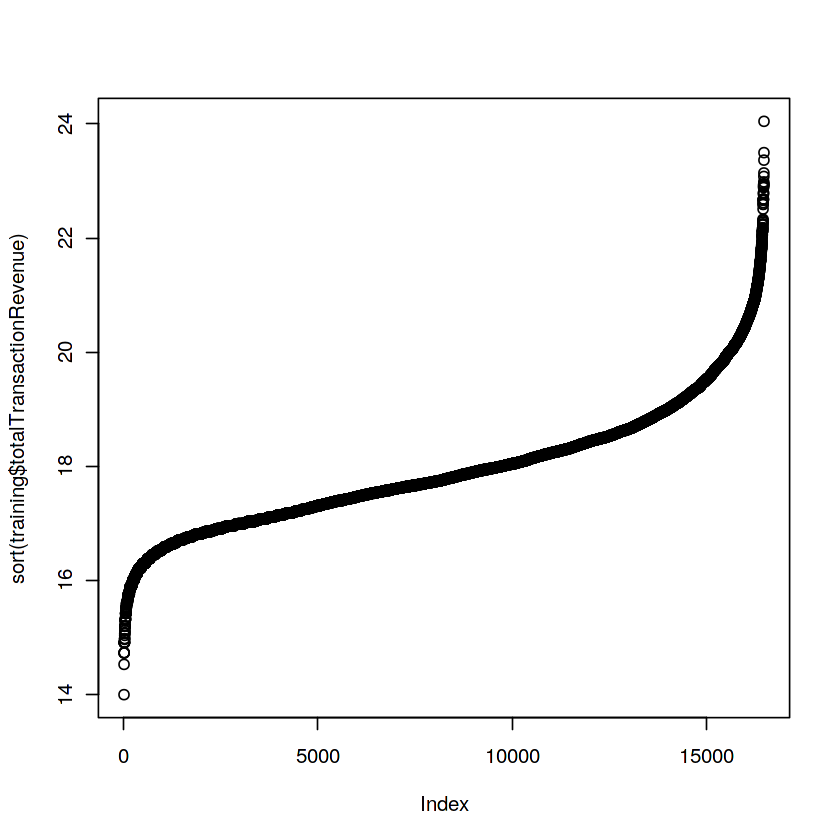

$train
$train$Training01
[1] 1

$train$Training02
[1] 1 2

$train$Training03
[1] 1 2 3

$train$Training04
[1] 1 2 3 4

$train$Training05
[1] 1 2 3 4 5

$train$Training06
[1] 1 2 3 4 5 6

$train$Training07
[1] 1 2 3 4 5 6 7

$train$Training08
[1] 1 2 3 4 5 6 7 8

$train$Training09
[1] 1 2 3 4 5 6 7 8 9

$train$Training10
 [1]  1  2  3  4  5  6  7  8  9 10

$train$Training11
 [1]  1  2  3  4  5  6  7  8  9 10 11

$train$Training12
 [1]  1  2  3  4  5  6  7  8  9 10 11 12

$train$Training13
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13

$train$Training14
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14

$train$Training15
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15

$train$Training16
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16

$train$Training17
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17

$train$Training18
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18

$train$Training19
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19


$test
$test$Testing01
[1] 2 3

$test$Testing02
[1] 3 4

$test$Testing03
[1] 4 5

$test$Testing04
[1] 5 6

$test$Testing05
[1] 6 7

$test$Testing06
[1] 7 8

$test$Testing07
[1] 8 9

$test$Testing08
[1]  9 10

$test$Testing09
[1] 10 11

$test$Testing10
[1] 11 12

$test$Testing11
[1] 12 13

$test$Testing12
[1] 13 14

$test$Testing13
[1] 14 15

$test$Testing14
[1] 15 16

$test$Testing15
[1] 16 17

$test$Testing16
[1] 17 18

$test$Testing17
[1] 18 19

$test$Testing18
[1] 19 20

$test$Testing19
[1] 20 21

[1] "Fitting the regression model..."
0:	learn: 16.5065928	total: 6.36ms	remaining: 1.26s
1:	learn: 15.7062768	total: 10.4ms	remaining: 1.03s
2:	learn: 14.9473938	total: 14ms	remaining: 917ms
3:	learn: 14.2257206	total: 18.6ms	remaining: 913ms
4:	learn: 13.5416652	total: 22.3ms	remaining: 868ms
5:	learn: 12.8912897	total: 25.6ms	remaining: 827ms
6:	learn: 12.2785085	total: 28.6ms	remaining: 789ms
7:	learn: 11.6920771	total: 32.3ms	remaining: 776ms
8:	learn: 11.1355640	total: 35.4ms	remaining: 751ms
9:	learn: 10.6058291	total: 39.1ms	remaining: 742ms
10:	learn: 10.1055828	total: 43ms	remaining: 739ms
11:	learn: 9.6267409	total: 46.3ms	remaining: 726ms
12:	learn: 9.1770447	total: 50ms	remaining: 720ms
13:	learn: 8.7501637	total: 53.4ms	remaining: 710ms
14:	learn: 8.3456737	total: 57.1ms	remaining: 704ms
15:	learn: 7.9660259	total: 60.3ms	remaining: 694ms
16:	learn: 7.5990007	total: 63.6ms	remaining: 684ms
17:	learn: 7.2534618	total: 67ms	remaining: 678ms
18:	learn: 6.9253958	total: 69.2m

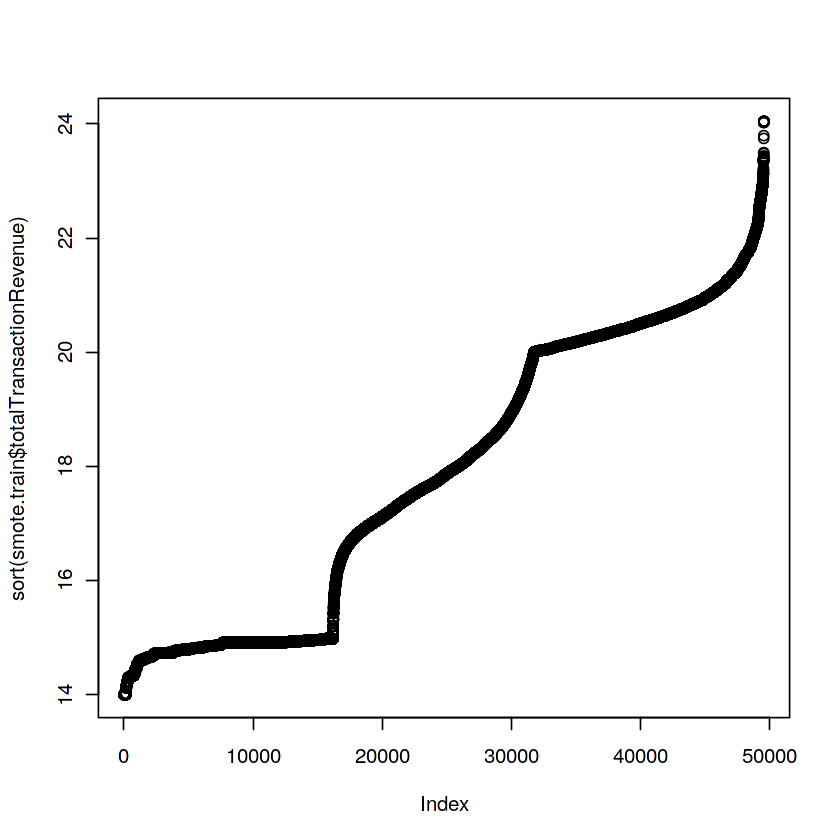

In [27]:
# Data preparation for regression
imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)
#--------------------------------------------------
cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value")

imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
imbal.data <- select(imbal.data, -c(hour, mday, wday, month))
#----------------------------------------------------
# Categorical attributes level reduction...
cols.nam <- c("networkDomain")
catTofac <- function(x, df){
    for (i in 1:length(x)){
        df[,x[i]] <- fct_lump(df[,x[i]], n = 20, w = NULL, other_level = "(Other)")
    }
    return(df)
}
imbal.data <- catTofac(cols.nam, imbal.data)
#-----------------------------------------
print("Normalizing the training set...")
cols.nam <- c("visitNumber", "hits", "timeOnSite", "sessionQualityDim", "freqVisit")

pp_norm <- preProcess(imbal.data[cols.nam], 
                      method = c("scale", "center"))
                      #method = c("range"))
imbal.data[cols.nam] <- predict(pp_norm, newdata = imbal.data[cols.nam])
#-------------------------------------
str(imbal.data)
test.data <- imbal.data %>%
    filter(ldate >= as.Date("2018-05-01"))
training <- imbal.data %>%
    filter(ldate < as.Date("2018-05-01"))
#-------------------------------------
#Data split
training <- training[which(training$totalTransactionRevenue != 0),] 
#training <- dataset %>%
#    filter(ldate < as.Date("2018-05-01"))
#validation <- dataset %>%
#    filter(ldate >= as.Date("2017-01-01"))
#------------------------------------
# Addressing imbalanced class: maybe we can do this in trainControl again?
set.seed(1)
print("Addressing imbalanced numeric class...")
#rel <- matrix(c(10, 1, 0, 15, 0, 0, 20, 1, 0), ncol = 3, nrow = 3, byrow = TRUE)
#smote.train <- SmoteRegress(totalTransactionRevenue~., training, thr.rel = 0.5, rel = rel, dist = "HEOM",
#                        C.perc = list(10, 1), k=5, repl=FALSE, p = 2)
#-------go with this one for now
training$ldate <- as.numeric(training$ldate)                 
rel <- matrix(c(13, 1, 0, 17, 0, 0, 23, 1, 0), ncol = 3, nrow = 3, byrow = TRUE)
smote.train <- SmoteRegress(totalTransactionRevenue~., training, thr.rel = 0.5, rel = rel, dist = "HEOM",
                        C.perc = list(900, 1, 20), k = 5, repl=FALSE, p = 2)

smote.train$ldate <- lubridate::as_datetime(smote.train$ldate)

plot(sort(training$totalTransactionRevenue))
plot(sort(smote.train$totalTransactionRevenue))

#-----------------------------------
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("fullVisitorId", "visitNumber", "hits", "sessionQualityDim", 
                                          "timeOnSite", "totalTransactionRevenue", "ldate", "freqVisit")])
    return(df)
}
#training <- cat.encode.func(smote.train)
training <- cat.encode.func(smote.train)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
#-------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
y_train <- unlist(training[c('totalTransactionRevenue')], use.names = FALSE)
x_train <- select(training, -c("totalTransactionRevenue"))
#y_valid <- unlist(validation[c('totalTransactionRevenue')], use.names = FALSE)
#x_valid <- select(validation, -c("totalTransactionRevenue"))

y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
#-------------------------------------
# Preparing dataset for timeSlices
temp <- training %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
# Creating time slices
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 2, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}
#-------------------------------------------          
fitControl <- trainControl(method = "timeslice",
                           #sampling = "smote",
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)                           
)
print("Fitting the regression model...")                   
set.seed(123)
grid <- expand.grid(depth = c(5, 7), #c(5,6,7),7
                    learning_rate = c(0.05, 0.1, 0.2), #c(0.2,0.1,0.05),0.05
                    iterations = 200, #c(50,100,200),200
                    l2_leaf_reg = 3,
                    rsm = 0.8, #c(0.8,1.0),0.8
                    border_count = c(64, 255))#c(64,128,255)) , 255
                   
smote.reg.model <- train(x = x_train[, !(colnames(x_train) %in% c("ldate", "fullVisitorId"))], 
                   y = y_train,
                   method = catboost.caret,
                   trControl = fitControl,
                   tuneGrid = grid,
                   task_type = "CPU",
                   thread_count = 4
              )
                   
saveRDS(smote.reg.model, "smote2.rollingwin.reg.rds")


Catboost 

16494 samples
   18 predictor

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 868, 1589, 2339, 3096, 4336, 5034, ... 
Resampling results across tuning parameters:

  depth  learning_rate  border_count  RMSE      Rsquared   MAE      
  5      0.05            64           1.008009  0.1734417  0.7808217
  5      0.05           255           1.009066  0.1722129  0.7815267
  5      0.10            64           1.003779  0.1813158  0.7766679
  5      0.10           255           1.004239  0.1833383  0.7765870
  5      0.20            64           1.005631  0.1851929  0.7760084
  5      0.20           255           1.008758  0.1832379  0.7773010
  7      0.05            64           1.038066  0.1364597  0.7992338
  7      0.05           255           1.037164  0.1392980  0.7990373
  7      0.10            64           1.036658  0.1525871  0.7945057
  7      0.10           255           1.033256  0.15416

Catboost 

49586 samples
   18 predictor

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (1 held-out with a fixed window) 
Summary of sample sizes: 2375, 4846, 7625, 10506, 14430, 17741, ... 
Resampling results across tuning parameters:

  depth  learning_rate  border_count  RMSE      Rsquared   MAE     
  5      0.05            64           1.534919  0.5602440  1.183817
  5      0.05           255           1.529932  0.5625029  1.179940
  5      0.10            64           1.482058  0.5826498  1.137160
  5      0.10           255           1.478435  0.5838015  1.137164
  5      0.20            64           1.451535  0.5960831  1.117144
  5      0.20           255           1.449797  0.5969465  1.109181
  7      0.05            64           1.537151  0.5590601  1.192420
  7      0.05           255           1.525837  0.5630840  1.179992
  7      0.10            64           1.504332  0.5722881  1.164448
  7      0.10           255           1.500761  0.5738450  1.

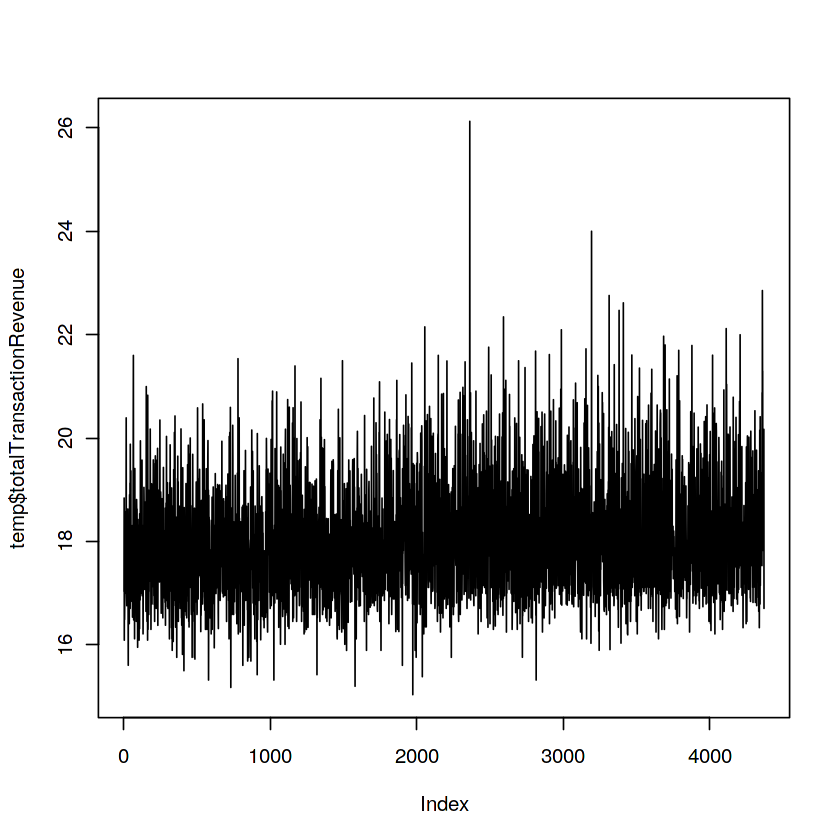

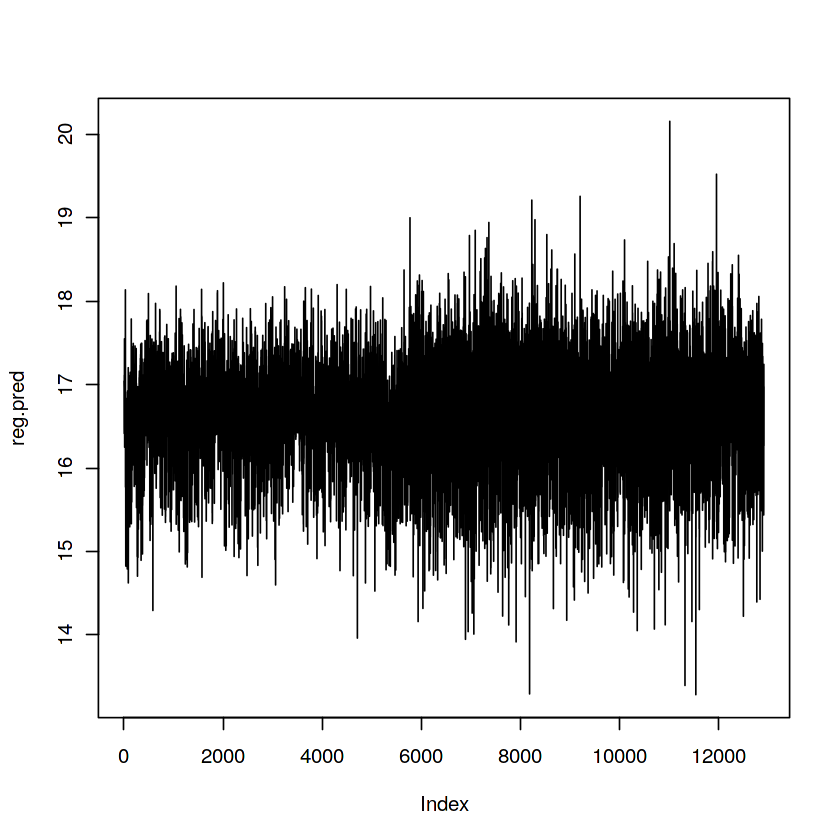

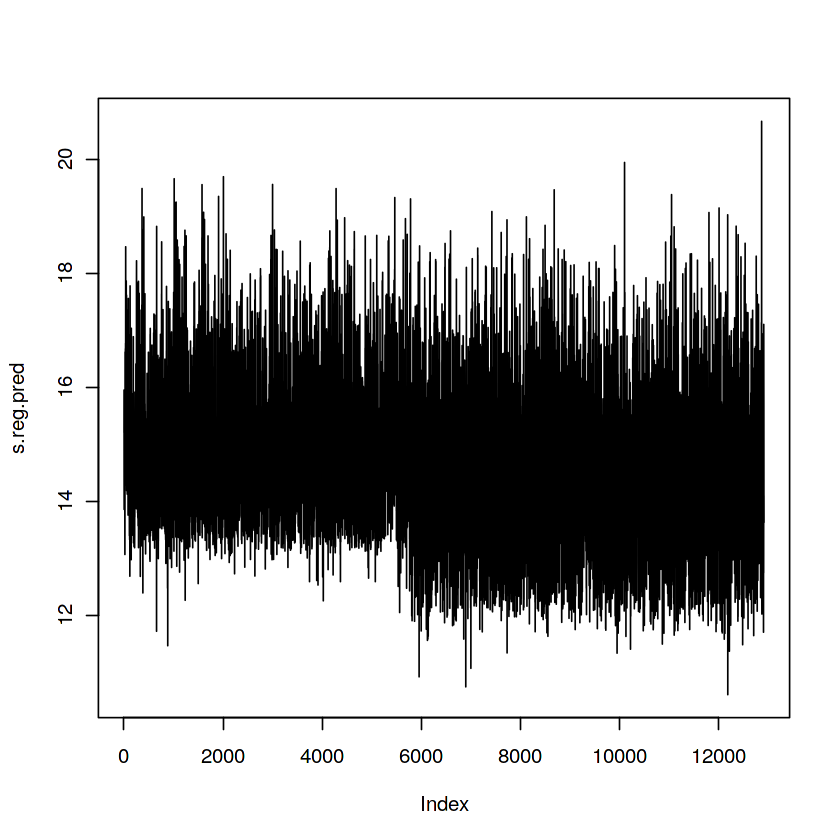

In [29]:
reg.model <- readRDS("../input/mylatestmodels/original.rollingwin.AUC.reg.rds")

#smote.reg.model <- readRDS("../input/mylatestmodels/original.fixedwin.AUC.reg.rds")                   
#pred_reg <- predict(reg.model, x_test)  
w.model <- readRDS("../input/mylatestmodels/weights.rollingwin.AUC.rds")
w.pred <- predict(w.model, x_test, type="prob")

x_test$Rev <- w.pred$Rev
x_test_new <- x_test %>%
filter(Rev > 0.9)
dim(x_test_new)                  
reg.pred <- predict(reg.model, x_test_new)
s.reg.pred <- predict(smote.reg.model, x_test_new)
# we do not have revenues for those time periods Dec 2018 to Jan 2019 to calculate RMSE and R2
#RMSE(reg.pred, y_valid)
#R2(reg.pred, y_valid)
reg.model
smote.reg.model
temp <- test.data %>% select(totalTransactionRevenue) %>%
                   filter(totalTransactionRevenue>0)
#par(mfrow=c(1,2))
plot(temp$totalTransactionRevenue, type="l")
plot(reg.pred, type="l")
plot <- plot(s.reg.pred, type="l")
                   
#require(gridExtra)
#plot1 <- qplot(1)
#plot2 <- qplot(1)
#grid.arrange(plot1, plot2, ncol=2)
# We can do different regression models e.g., original sampled datasets, fixed vs rolling window

In [ ]:
library(clustMixType)
temp <- select(imbal.data, -c("ldate", "fullVisitorId", "totalTransactionRevenue"))
kmc <- kproto(temp, 2, lambda = NULL, iter.max = 100,
  nstart = 1, na.rm = TRUE, keep.data = FALSE, verbose = FALSE)

In [ ]:
library(mboost)
set.seed(123) 
y_train = training$totalTransactionRevenue
str(training)
fitControl <- trainControl(method = "timeslice",
                           classProbs = TRUE,
                           #sampling = "smote",
                           #summaryFunction = twoClassSummary,
                           summaryFunction = prSummary,
                           #savePredictions = TRUE,
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)
                           #indexFinal = unlist(indexFinal)
)

print("glmboost model fitting...")
model <- train(totalTransactionRevenue ~ .,
               data = training[, !(colnames(training) %in% c("ldate", "fullVisitorId"))], 
               #y = y_train,
               method = "glmboost",
               #control = boost_control(mstop = 100),
               #mstop = 2000,
               #tuneLength=5, 
               #mstop = 100, 
               #nu = 0.1,
               center=FALSE, 
               family=binomial(),
               #method = "gbm",
               #weights = model_weights,
               trControl = fitControl,
               #tuneGrid = catboost.grid,
               #tuneLength = 3,
               metric = "AUC"
               #metric = "F", 
               #task_type = "CPU",# performance settings
               #thread_count = 4 # thread_count equal to the number of cpu cores which is 4  
              )

saveRDS(model, "glmboost.rds")